# Pre-operative Imaging Concordance Analysis


### Key Terms


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('Data/raw_imaging_data.xlsx')

In [3]:
# Clean column names by removing whitespace
preop_imaging_df.columns = preop_imaging_df.columns.str.strip()

## Concordance Analysis

Calculates how well each imaging modality's findings match surgical findings, categorized as Exact, Side, or Incorrect Localization.

In [4]:
# Calculate Concordance for Each Modality
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

In [5]:
"""
    Determines concordance between imaging modality findings and surgical findings.

    Parameters:
        row (pd.Series): A row from the dataframe containing imaging and surgical data.
        modality_col (str): The column name of the imaging modality to evaluate.

    Returns:
        str: Concordance category, one of:
            - 'Yes (Exact)'
            - 'Yes (Side)'
            - 'Incorrect Localization'
            - 'Non-localizing'
            - 'No Scan'
            - 'Unknown'
"""

def check_concordance(row, modality_col):
    
    imaging = row[modality_col]
    surgical = row['Surgical Findings']

    # Return Unknown if imaging or surgical data is missing
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'

    # Handle No Scan and Non-localizing 
    if imaging == 'No Scan':
        return 'No Scan'
    if imaging == 'Non-localizing':
        return 'Non-localizing'

    # If surgery found 4 gland hyperplasia, any single imaging finding is incorrect
    if 'hyperplasia' in surgical.lower():
        return 'Incorrect Localization'

    # Split and clean imaging and surgical gland strings into sets
    imaging_glands = [g.strip().lower() for g in imaging.split(',')]
    surgical_glands = [g.strip().lower() for g in surgical.split(',')]
    imaging_set = set(imaging_glands)
    surgical_set = set(surgical_glands)

    # Exact match: all surgical glands found in imaging
    if surgical_set.issubset(imaging_set):
        return 'Yes (Exact)'


    # Side match analysis
    imaging_sides = ['left' for ig in imaging_glands if 'left' in ig] + \
                    ['right' for ig in imaging_glands if 'right' in ig]
    surgical_sides = ['left' for sg in surgical_glands if 'left' in sg] + \
                     ['right' for sg in surgical_glands if 'right' in sg]
    
    # Multi-gland surgery with side match Partial
    if any(side in surgical_sides for side in imaging_sides):
        # Single gland surgery with side match Side match
        return 'Yes (Side)'

    return 'Incorrect Localization'

In [6]:
# Loop through modalities and collect counts + percentages

summary_data = []

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'

    # Calculate concordance for each row and store in a new column
    preop_imaging_df[concordance_col] = preop_imaging_df.apply(
        lambda row: check_concordance(row, modality), axis=1
    )
    
    # Filter to localizing rows only
    localizing_df = preop_imaging_df[
        ~preop_imaging_df[concordance_col].isin(['Unknown', 'Non-localizing'])
    ].copy()
    
    # Calculate value counts and total count
    counts = localizing_df[concordance_col].value_counts()
    total = counts.sum()
    
    for match_type, count in counts.items():
        pct = round((count / total) * 100 if total > 0 else 0, 2)
        
        # Append results as dictionaries to summary_data list
        summary_data.append({
            'Modality': modality,
            'Concordance': match_type,
            'Count': count,
            'Percentage': pct
        })

In [7]:
# Convert to DataFrame
concordance_summary_df = pd.DataFrame(summary_data)

# Pivot for grouped bar plot preparation (optional)
pivot_df = concordance_summary_df.pivot(index='Modality', columns='Concordance', values='Percentage').fillna(0)

# Reorder columns 
ordered_cols = ['Yes (Exact)', 'Yes (Side)', 'Incorrect Localization']
pivot_df = pivot_df.reindex(columns=ordered_cols).fillna(0)

# Display results
display(concordance_summary_df)
display(pivot_df)

,Modality,Concordance,Count,Percentage
0,SPECT/CT,Yes (Side),91,51.12
1,SPECT/CT,Yes (Exact),72,40.45
2,SPECT/CT,Incorrect Localization,15,8.43
3,4D CT Scan,Yes (Exact),78,45.09
4,4D CT Scan,Yes (Side),68,39.31
5,4D CT Scan,Incorrect Localization,27,15.61
6,Ultrasound,Yes (Side),41,52.56
7,Ultrasound,Yes (Exact),26,33.33
8,Ultrasound,Incorrect Localization,11,14.10
9,Sestamibi,Yes (Side),66,58.41


Concordance,Yes (Exact),Yes (Side),Incorrect Localization
Modality,,,
4D CT Scan,45.09,39.31,15.61
MRI,50.00,25.00,25.00
SPECT/CT,40.45,51.12,8.43
Sestamibi,40.71,58.41,0.88
Ultrasound,33.33,52.56,14.10


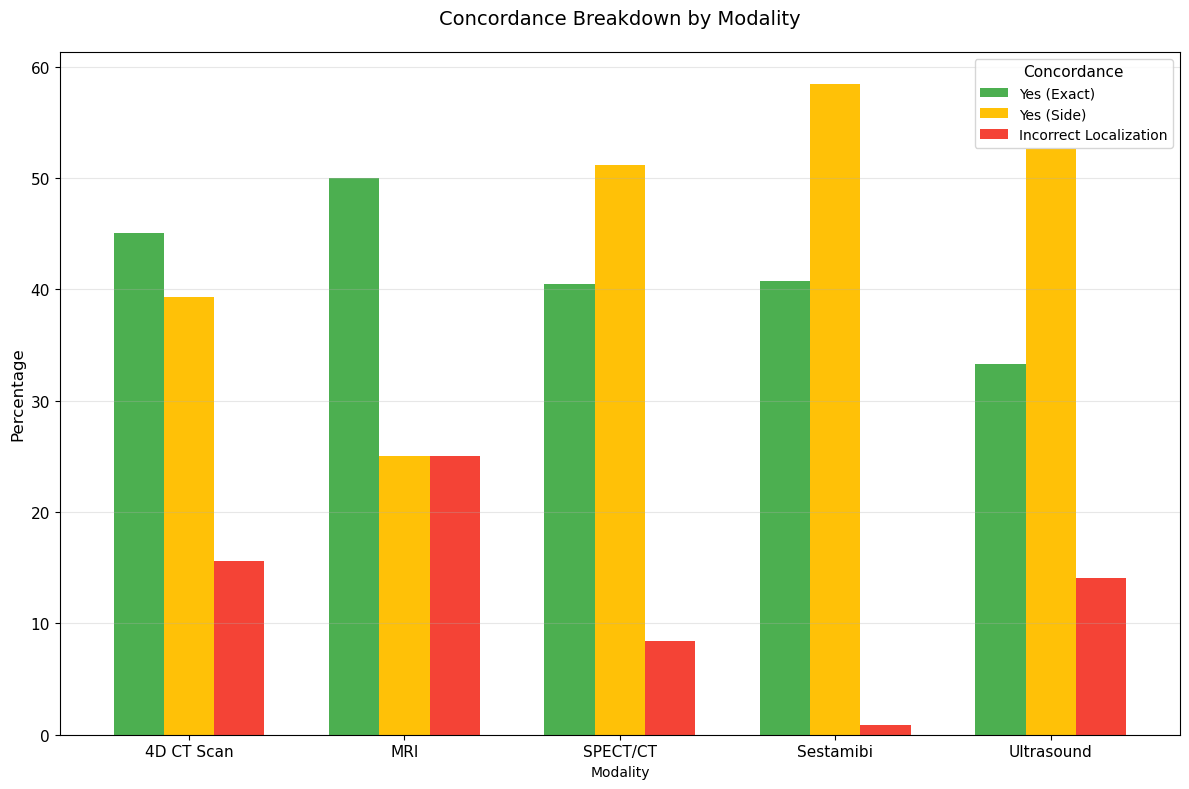

In [8]:
# Plot grouped bar plot
pivot_df.plot(
    kind='bar',
    figsize=(12,8),
    color=['#4CAF50', '#FFC107', '#F44336'],  # green, yellow, red
    width=0.7
)

plt.ylabel('Percentage', fontsize=12)
plt.title('Concordance Breakdown by Modality', fontsize=14, pad=20)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Concordance', fontsize=10, title_fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
preop_imaging_df.columns

Index(['Date of Procedure', 'Patient ID', 'Age', 'Gender', 'Surgical Findings',
       'Surgical Cure', 'SPECT/CT', 'Ultrasound', '4D CT Scan', 'Sestamibi',
       'MRI', 'SPECT/CT Calculated Concordance',
       '4D CT Scan Calculated Concordance',
       'Ultrasound Calculated Concordance', 'Sestamibi Calculated Concordance',
       'MRI Calculated Concordance'],
      dtype='object')

In [12]:
# create a function to extract the side 
def extract_surgical_side(surgical):
    # check if the surgical side is null
    if pd.isnull(surgical):
        return 'Unknown'
    
    surgical = surgical.lower()
    has_left = 'left' in surgical
    has_right = 'right' in surgical

    if has_left and has_right:
        return 'Left & Right'
    elif has_left:
        return 'Left'
    elif has_right:
        return 'Right'
    else:
        return 'Unknown'

# Apply to dataframe
preop_imaging_df['Surgical Side'] = preop_imaging_df['Surgical Findings'].apply(extract_surgical_side)
preop_imaging_df.to_excel('Data/Clean_imaging_data.xlsx', index=False)
